In [32]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import io
import os
import cv2
from tqdm import tqdm
import albumentations as A
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics
import random
from albumentations.pytorch.transforms import ToTensorV2
import shutil

In [32]:
# read dataframe

os.chdir(r'C:\WORKS\Master_Thesis\DeepGlobeDataset\archive')

train = pd.read_csv(os.path.join(os.getcwd(), 'metadata.csv'))
test = train[train['split'] == 'test']
val = train[train['split'] == 'val']
train = train[train['split'] == 'train']


# size of file
train.shape

(6226, 4)

#### Utils

In [33]:
class CFG:
    seed = 42


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)
seed_everything(CFG.seed)



# plots mask image
def show_mask(masks, figsize=(10, 10)):
    f, axarr = plt.subplots(figsize=figsize)
    axarr.imshow(masks, cmap='gray')


def show_rgb_image(rgb_image, figsize=(10, 10)):
    f, axarr = plt.subplots(figsize=figsize)
    axarr.imshow(rgb_image)


def plot_images(**image_cmap_pairs):
    """PLot images in one row
    """
    n = len(image_cmap_pairs)
    plt.figure(figsize=(16, 5))
    for i, (name, image_cmap) in enumerate(image_cmap_pairs.items()):
        image, cmap = image_cmap
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')))
        plt.imshow(image, cmap=cmap)
    plt.tight_layout()
    plt.show()

#### Custom Dataset Class

In [34]:
class DeepGlobeDataset(torch.utils.data.Dataset):
    CLASSES = ['road_boundary', 'road_footprint']
    
    def __init__(
                self,
                data_list,
                image_dir,
                mask_dir,
                classes=None,
                augmentation=None
                ):
        
       
        
        # generate full path to image/mask file
        self.image_paths, self.mask_paths = [], []
        for data in data_list:
            self.image_paths.append(os.path.join(image_dir, data))
            mask_name = data.split('/')[-1].split('.')[0].split('_')[0] + '_mask.png'
            self.mask_paths.append(os.path.join(mask_dir, mask_name))
         
        # convert str names to class values on masks
        if not classes:
            classes = self.CLASSES
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        print(self.class_values)
        
        # initialise augmentation if it exists
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        image = io.imread(self.image_paths[i])
        mask = io.imread(self.mask_paths[i])

        # extract certain classes from mask
        mask = mask[:, :, 0]
        # normalise mask
        mask = mask/255
                             
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
       
        # for the returned mask, 0 is boundary 1 is the footprint(full mask)  
        return image, mask
    
    def __len__(self):
        return len(self.image_paths)
    
    def mask_channel_of(self, class_name):
        assert class_name in self.CLASSES
        return self.class_values.index(self.CLASSES.index(class_name))

    


#### Augmentations

In [35]:
def get_training_augmentation():
    train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(normalization='min_max_per_channel'),
        ToTensorV2(),
    ])
    return train_transform


def get_validation_augmentation():
    test_transform = A.Compose([
        A.Normalize(normalization='min_max_per_channel'),
        ToTensorV2(),
    ])
    return test_transform


In [36]:
#### Visualize resulted augmented images and masks

train_list = train['sat_image_path'].tolist()[0:11]
image_dir = r'C:\WORKS\Master_Thesis\DeepGlobeDataset\archive'
mask_dir = r'C:\WORKS\Master_Thesis\DeepGlobeDataset\archive\train'

# Custom dataset
train_dataset = DeepGlobeDataset(train_list, image_dir, mask_dir, augmentation=get_training_augmentation())


# Dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False)


channel_footprint = train_dataset.mask_channel_of('road_footprint')
channel_boundary = train_dataset.mask_channel_of('road_boundary')

for i in [1, 5, 9]:
    image, mask = train_dataset.__getitem__(i)

    image = image.permute(1, 2, 0)


    # plot_images(
    #     satellite_image=(image[:, :, :], 'gray'),
    #     road_boundary=(mask[:, :, 0], 'viridis'),
    # )

[0, 1]


In [37]:
image, mask = train_dataset.__getitem__(i)

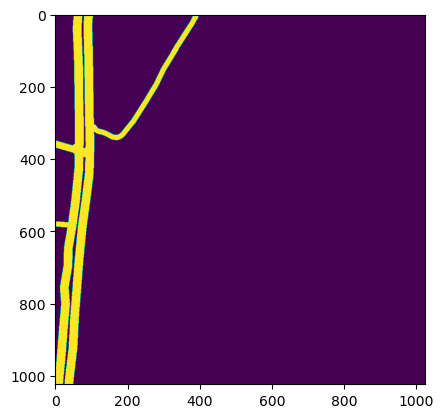

In [38]:
plt.imshow(mask)

#### Modelling

In [39]:
ENCODER = 'efficientnet-b2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['road_footprint']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
    in_channels=3
)

In [40]:
smp.utils.losses?

Type:        module
String form: <module 'segmentation_models_pytorch.utils.losses' from 'c:\\Users\\Propietario\\miniconda3\\envs\\datascience\\lib\\site-packages\\segmentation_models_pytorch\\utils\\losses.py'>
File:        c:\users\propietario\miniconda3\envs\datascience\lib\site-packages\segmentation_models_pytorch\utils\losses.py
Docstring:   <no docstring>

In [41]:
loss = smp.utils.losses.DiceLoss(activation='sigmoid')
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.AdamW([ 
    dict(params=model.parameters(), lr=1e-3),
])

In [42]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

val_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [48]:
all_images

[]

In [55]:
all_images =['train/'+ f for f in os.listdir(image_dir + '/train') if f.endswith('.jpg')]
train_list = random.sample(all_images, k=int(0.75 * len(all_images)))
val_list = [image for image in all_images if image not in train_list]
        

# Custom dataset
train_dataset = DeepGlobeDataset(train_list[:50], image_dir, mask_dir, augmentation=get_training_augmentation())
val_dataset = DeepGlobeDataset(val_list[:50], image_dir, mask_dir, augmentation=get_training_augmentation())


# Dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

[0, 1]
[0, 1]


In [56]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    val_logs = val_epoch.run(val_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < val_logs['iou_score']:
        max_score = val_logs['iou_score']
        torch.save(model, './deadline_best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 50/50 [00:05<00:00,  9.93it/s, dice_loss - 0.9175, iou_score - 0.1854]
Model saved!

Epoch: 1
valid: 100%|██████████| 50/50 [00:05<00:00,  9.91it/s, dice_loss - 0.9166, iou_score - 0.1943]
Model saved!

Epoch: 2
valid: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s, dice_loss - 0.9169, iou_score - 0.2271]
Model saved!

Epoch: 3
valid: 100%|██████████| 50/50 [00:04<00:00, 10.95it/s, dice_loss - 0.9172, iou_score - 0.2195]

Epoch: 4
valid: 100%|██████████| 50/50 [00:04<00:00, 10.81it/s, dice_loss - 0.9181, iou_score - 0.1991]

Epoch: 5
valid: 100%|██████████| 50/50 [00:04<00:00, 10.87it/s, dice_loss - 0.9192, iou_score - 0.157] 

Epoch: 6
valid: 100%|██████████| 50/50 [00:04<00:00, 10.79it/s, dice_loss - 0.9258, iou_score - 0.06021]

Epoch: 7
valid: 100%|██████████| 50/50 [00:04<00:00, 10.95it/s, dice_loss - 0.9207, iou_score - 0.1019] 

Epoch: 8
valid: 100%|██████████| 50/50 [00:04<00:00, 11.15it/s, dice_loss - 0.9258, iou_score - 0.0713] 

Epoch: 9
val

In [ ]:
# val score
#0.9568 - min-max
#0.9539 - image_per_channel

#epoch 1 - 0.954
#EPOCH 5 - 0.9522

In [57]:
val_dataset = DeepGlobeDataset(
    val_list[1409:1411],
    image_dir,
    mask_dir,
    classes=1,
    augmentation=get_validation_augmentation(),
    # preprocessing=get_preprocessing()
)

TypeError: 'int' object is not iterable

In [17]:
image, mask = val_dataset.__getitem__(1)

In [66]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

In [67]:
with torch.no_grad():
    for image, mask in val_loader:
        output = model(image.to(DEVICE))
        break

In [68]:
output = output.squeeze(0)

In [69]:
first_channel = output[0]

In [70]:
first_output = (first_channel > 0.5).float()

In [71]:
first_output = first_output.cpu().numpy()

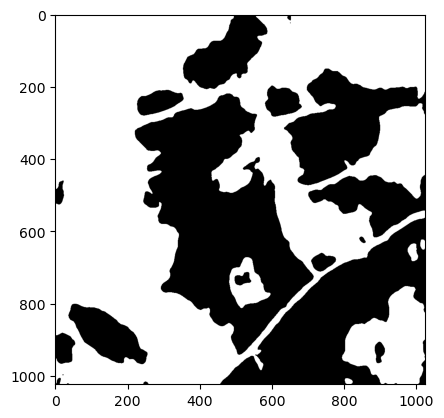

In [72]:
plt.imshow(first_output, cmap='gray')

In [168]:
squeeze_mask = torch.squeeze(mask, dim=0)

In [169]:
first_channel = squeeze_mask[0]

In [170]:
first_channel = first_channel.cpu().numpy()

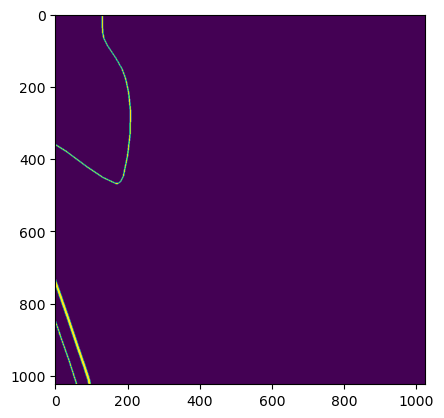

In [171]:
plt.imshow(first_channel)

In [38]:
squeeze_image = image.squeeze(0)

In [39]:
squeeze_image = squeeze_image.permute(1, 2, 0)

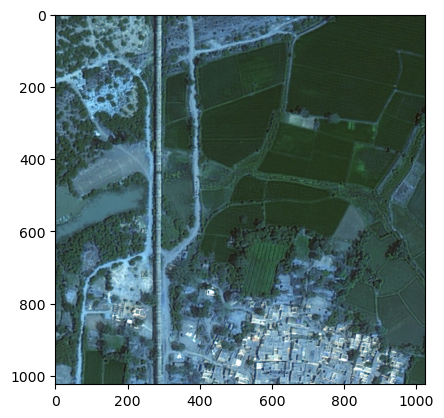

In [40]:
plt.imshow(squeeze_image.cpu().numpy())

#### Training

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from loss_optim_LR_utils import Dice_loss, Focal_Loss, ConLoss, f_score, CE_Loss
from torch.nn import nn
import numpy as np



def train_and_validate(
    model, 
    train_loader, 
    val_loader, 
    # criterion, 
    optimizer, 
    epochs, 
    device, 
    scheduler=None, 
    fp16=False, 
    scaler=None,
    cls_weights = np.array([1, 3], dtype=np.float32)
):
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        
        # Training Phase
        model.train()
        train_loss = 0.0
        train_fscore = 0.0

        with torch.no_grad():
            weights = torch.from_numpy(cls_weights)
        
        pbar = tqdm(total=len(train_loader), desc="Training", leave=False)
        for imgs, pngs, con_1, con_3, labels in train_loader:
            imgs, pngs, con_1, con_3, labels, weights = imgs.to(device), pngs.to(device), con_1.to(device), con_3.to(device), labels.to(device), weights.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast(fp16):
                outputs, r1, r3 = model(imgs)  # Forward pass
                loss = CE_Loss(outputs, pngs, cls_weights=weights, num_classes=2)  # Main loss (e.g., CE_Loss)
                
                # Add additional loss components
                c1_loss = ConLoss(r1, con_1)
                c3_loss = ConLoss(r3, con_3)
                lad = 0.4
                loss = loss + lad * (0.6 * c3_loss + 0.4 * c1_loss)

                # Calculate Dice loss, if applicable
               
                main_dice = Dice_loss(outputs, labels)
                loss += main_dice
                
                # Calculate f-score
                fscore = f_score(outputs, labels)
            
            if fp16:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            
            train_loss += loss.item()
            train_fscore += fscore.item()
            pbar.update(1)

        pbar.close()
        train_loss /= len(train_loader)
        train_fscore /= len(train_loader)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_fscore = 0.0
        
        with torch.no_grad():
            pbar = tqdm(total=len(val_loader), desc="Validation", leave=False)
            for imgs, pngs, con_1, con_3, labels in val_loader:
                imgs, pngs, con_1, con_3, labels, weights = imgs.to(device), pngs.to(device), con_1.to(device), con_3.to(device), labels.to(device), weights.to(device)

                outputs, r1, r3 = model(imgs)  # Forward pass
                loss = CE_Loss(outputs, pngs, cls_weights=weights, num_classes=2) # Main loss
                
                # Add additional loss components
                c1_loss = ConLoss(r1, con_1)
                c3_loss = ConLoss(r3, con_3)
                lad = 0.4
                loss = loss + lad * (0.6 * c3_loss + 0.4 * c1_loss)

                # Calculate Dice loss, if applicable
                main_dice = Dice_loss(outputs, labels)
                loss += main_dice
                
                # Calculate f-score
                fscore = f_score(outputs, labels)

                val_loss += loss.item()
                val_fscore += fscore.item()
                pbar.update(1)

            pbar.close()
            val_loss /= len(val_loader)
            val_fscore /= len(val_loader)

        # Print epoch summary
        print(f"Epoch {epoch + 1} Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train F-Score: {train_fscore:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val F-Score: {val_fscore:.4f}")

        # Learning rate scheduler step
        if scheduler:
            scheduler.step(val_loss)


####  Sampling 20% of train and validation images

* save them to folder

In [30]:
random.seed(42)
all_images_masks = os.listdir(r'C:\WORKS\Master_Thesis\DeepGlobeDataset\archive\train')
all_images = [image for image in all_images_masks if 'jpg' in image]
sampled_images = random.sample(all_images, 1244)

In [33]:
# sampled_masks
sampled_masks = [id.split('_')[0] + '_mask.png' for id in sampled_images]

In [35]:
# # Source directory
# source_dir = r"C:\WORKS\Master_Thesis\DeepGlobeDataset\archive\train"

# # Destination directory
# destination_dir = r"C:\WORKS\Master_Thesis\DeepGlobeDataset\archive\sampled"

# # Ensure destination directory exists
# os.makedirs(destination_dir, exist_ok=True)

# # Iterate over files in the source directory
# for filename in tqdm(sampled_images):
#     source_path = os.path.join(source_dir, filename)
#     destination_path = os.path.join(destination_dir, filename)
    
#     # Copy the file
#     if os.path.isfile(source_path):  # Check if it's a file (not a directory)
#         shutil.copy(source_path, destination_path)

# print(f"Copied all img filenames")

# for filename in tqdm(sampled_masks):
#     source_path = os.path.join(source_dir, filename)
#     destination_path = os.path.join(destination_dir, filename)
    
#     # Copy the file
#     if os.path.isfile(source_path):  # Check if it's a file (not a directory)
#         shutil.copy(source_path, destination_path)
        
# print(f"Copied all mask filenames")


100%|██████████| 1244/1244 [00:01<00:00, 1148.60it/s]


Copied all img filenames


100%|██████████| 1244/1244 [00:00<00:00, 1523.15it/s]

Copied all mask filenames


#### Viewing Predictions

In [138]:
import torch
from segformer import SegFormer
from tqdm import tqdm
from dataset_utils import SegmentationDataset, seg_dataset_collate
from torch.utils.data import DataLoader
from train_val_utils import validate_one_epoch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imsave

def save_pred_segmentations(phi,
                            best_model_path:str,
                            images_ids: list,
                            images_directory: str,
                            save_dir: str,
                            png=False,
                            lad=None

                                   ):
    
    
    # load model
    model = SegFormer(num_classes=2, phi=phi, pretrained=True)
    device= 'cuda'
    model.load_state_dict(torch.load(best_model_path))
    model.to(device)
    model.eval() 

    # dataloader
    eval_dataset = SegmentationDataset(images_list= images_ids,
                                        input_shape=[512, 512],
                                        num_classes=2,
                                        train=False,
                                        images_directory=images_directory,
                                        labels_directory=images_directory
                                        )
    
    eval_dataloader = DataLoader(dataset=eval_dataset,
           batch_size=4,
           shuffle=False,
           collate_fn=seg_dataset_collate
           )
    
    with torch.no_grad():
       for imgs, pngs, con_1, con_3, labels in tqdm(eval_dataloader, desc="predictions", leave=False):
             imgs, pngs, con_1, con_3, labels = imgs.to(device), pngs.to(device), con_1.to(device), con_3.to(device), labels.to(device)
             # Forward pass
             outputs, r1, r3 = model(imgs)
             break

       

       # get the first prediction in the batch
       for index in range(outputs.shape[0]):

              if not png:
                     # save numpy as image
                     probabilities = F.softmax(outputs[index, :, :, :], dim=0)

                     predicted_classes = torch.argmax(probabilities, dim=0)
                     pred_image = predicted_classes.detach().cpu().numpy()

                     array = pred_image.astype(np.uint8)
                     
                     array = array * 255
                     

                     image = Image.fromarray(array)
                     # plt.axis('off')
                     # plt.title(f'image_index_{images_ids[index]} ')
                     # plt.imshow(array, cmap='gray')
                     # plt.show()
                     imsave(f"{save_dir}/{images_ids[index].split('.')[0]}_lad_{lad}.png", array)
              else:
                     pred_image = png[index, :, :, :].detach().cpu().numpy()

                     array = pred_image.astype(np.uint8)

                     # # image = Image.fromarray(array)
                     # plt.axis('off')
                     # plt.title(f'image_index_{images_ids[index]} ')
                     # plt.imshow(array, cmap='gray')
                     # plt.show()
                   
        

In [155]:
save_pred_segmentations(phi = 'b0',
                        best_model_path=r"C:\WORKS\Master_Thesis\Codes\DeepGlobe\logs\modelB0_lad_0.7_epoch50_lr1e-4\weights\best\modelB0_lad_0.7_epoch50_lr1e-4_best.pth",
                        images_directory=r"C:\WORKS\Master_Thesis\DeepGlobeDataset\archive\train",
                        images_ids=['11545_sat.jpg',  '428579_sat.jpg', '775963_sat.jpg', '392105_sat.jpg'], #'392105_sat.jpg', #'775963_sat.jpg'
                        save_dir=r"C:\WORKS\Master_Thesis\Codes\DeepGlobe\pred_masks",
                        lad = 0.7
                        )

C:\Users\Propietario\AppData\Local\Temp\ipykernel_23672\3510196306.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Loading backbone weights.....
Loaded backbone weights


In [102]:
0.1 = 0.742

0.4 = 0.737

(1024, 1024, 3)

In [48]:
# save_pred_segmentations(phi = 'b0',
#                         best_model_path=r"C:\WORKS\Master_Thesis\Codes\DeepGlobe\logs\model_B0_with_PCS_lr1e-3_epoch10_BS16_F16False_FreezeFalse\weights\best\model_B0_with_PCS_lr1e-3_epoch10_BS16_F16False_FreezeFalse_best.pth",
#                         images_directory=r"C:\WORKS\Master_Thesis\DeepGlobeDataset\archive\train",
#                         images_ids=['11480_sat.jpg',  '428579_sat.jpg', '392105_sat.jpg'], #'392105_sat.jpg', #'775963_sat.jpg'
#                         save_dir=r"C:\WORKS\Master_Thesis\Codes\DeepGlobe\logs\model_B2_with_PCS\outputs"
#                         )

In [1]:
from skimage.morphology import skeletonize, remove_small_objects, remove_small_holes
import numpy as np
from matplotlib.pylab import plt
import cv2
from other_tools import sknw
import os
import pandas as pd
from functools import partial
from itertools import tee
from scipy.spatial.distance import pdist, squareform
from scipy import ndimage as ndi
from collections import defaultdict, OrderedDict
import sys
import random


from multiprocessing import Pool

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def remove_sequential_duplicates(seq):
    #todo
    res = [seq[0]]
    for elem in seq[1:]:
        if elem == res[-1]:
            continue
        res.append(elem)
    return res

def remove_duplicate_segments(seq):
    seq = remove_sequential_duplicates(seq)
    segments = set()
    split_seg = []
    res = []
    for idx, (s, e) in enumerate(pairwise(seq)):
        if (s, e) not in segments and (e, s) not in segments:
            segments.add((s, e))
            segments.add((e, s))
        else:
            split_seg.append(idx+1)
    for idx, v in enumerate(split_seg):
        if idx == 0:
            res.append(seq[:v])
        if idx == len(split_seg) - 1:
            res.append(seq[v:])
        else:
            s = seq[split_seg[idx-1]:v]
            if len(s) > 1:
                res.append(s)
    if not len(split_seg):
        res.append(seq)
    return res


def flatten(l):
    return [item for sublist in l for item in sublist]


def get_angle(p0, p1=np.array([0,0]), p2=None):
    """ compute angle (in degrees) for p0p1p2 corner
    Inputs:
        p0,p1,p2 - points in the form of [x,y]
    """
    if p2 is None:
        p2 = p1 + np.array([1, 0])
    v0 = np.array(p0) - np.array(p1)
    v1 = np.array(p2) - np.array(p1)

    angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
    return np.degrees(angle)

def preprocess(img, thresh):
    img = (img > (255 * thresh)).astype(np.bool)
    remove_small_objects(img, 300, in_place=True)
    remove_small_holes(img, 300, in_place=True)
    # img = cv2.dilate(img.astype(np.uint8), np.ones((7, 7)))
    return img

def graph2lines(G):
    node_lines = []
    edges = list(G.edges())
    if len(edges) < 1:
        return []
    prev_e = edges[0][1]
    current_line = list(edges[0])
    added_edges = {edges[0]}
    for s, e in edges[1:]:
        if (s, e) in added_edges:
            continue
        if s == prev_e:
            current_line.append(e)
        else:
            node_lines.append(current_line)
            current_line = [s, e]
        added_edges.add((s, e))
        prev_e = e
    if current_line:
        node_lines.append(current_line)
    return node_lines


def visualize(img, G, vertices):
    plt.imshow(img, cmap='gray')

    # draw edges by pts
    for (s, e) in G.edges():
        vals = flatten([[v] for v in G[s][e].values()])
        for val in vals:
            ps = val.get('pts', [])
            plt.plot(ps[:, 1], ps[:, 0], 'green')

    # draw node by o
    node, nodes = G.node(), G.nodes
    # deg = G.degree
    # ps = np.array([node[i]['o'] for i in nodes])
    ps = np.array(vertices)
    plt.plot(ps[:, 1], ps[:, 0], 'r.')

    # title and show
    plt.title('Build Graph')
    plt.show()

def line_points_dist(line1, pts):
    return np.cross(line1[1] - line1[0], pts - line1[0]) / np.linalg.norm(line1[1] - line1[0])

def remove_small_terminal(G):
    deg = G.degree()
    terminal_points = [i for i, d in deg.items() if d == 1]
    edges = list(G.edges())
    for s, e in edges:
        if s == e:
            sum_len = 0
            vals = flatten([[v] for v in G[s][s].values()])
            for ix, val in enumerate(vals):
                sum_len += len(val['pts'])
            if sum_len < 3:
                G.remove_edge(s, e)
                continue
        vals = flatten([[v] for v in G[s][e].values()])
        for ix, val in enumerate(vals):
            if s in terminal_points and val.get('weight', 0) < 10:
                G.remove_node(s)
            if e in terminal_points and val.get('weight', 0) < 10:
                G.remove_node(e)
    return


linestring = "LINESTRING {}"
def make_skeleton(img_array, fix_borders=False, debug=False):
    replicate = 5
    clip = 2
    rec = replicate + clip
    # open and skeletonize
    # img = cv2.imread(os.path.join(root, fn), cv2.IMREAD_GRAYSCALE)
    # assert img.shape == (1300, 1300)
    img = img_array.copy()
    if fix_borders:
        img = cv2.copyMakeBorder(img, replicate, replicate, replicate, replicate, cv2.BORDER_REPLICATE)
    img_copy = None

    if debug:
        if fix_borders:
            img_copy = np.copy(img[replicate:-replicate,replicate:-replicate])
        else:
            img_copy = np.copy(img)

    if not np.any(img):
        return None, None
    ske = skeletonize(img).astype(np.uint16)
    if fix_borders:
        ske = ske[rec:-rec, rec:-rec]
        ske = cv2.copyMakeBorder(ske, clip, clip, clip, clip, cv2.BORDER_CONSTANT, value=0)
    return img_copy, ske


def add_small_segments(G, terminal_points, terminal_lines):
    node = G.nodes
    term = [node[t]['o'] for t in terminal_points]
    dists = squareform(pdist(term))
    possible = np.argwhere((dists > 0) & (dists < 20))
    good_pairs = []
    for s, e in possible:
        if s > e:
            continue
        s, e = terminal_points[s], terminal_points[e]

        if G.has_edge(s, e):
            continue
        good_pairs.append((s, e))

    possible2 = np.argwhere((dists > 20) & (dists < 100))
    for s, e in possible2:
        if s > e:
            continue
        s, e = terminal_points[s], terminal_points[e]
        if G.has_edge(s, e):
            continue
        l1 = terminal_lines[s]
        l2 = terminal_lines[e]
        d = line_points_dist(l1, l2[0])

        if abs(d) > 20:
            continue
        angle = get_angle(l1[1] - l1[0], np.array((0, 0)), l2[1] - l2[0])
        if -20 < angle < 20 or angle < -160 or angle > 160:
            good_pairs.append((s, e))

    dists = {}
    for s, e in good_pairs:
        s_d, e_d = [G.nodes[s]['o'], G.nodes[e]['o']]
        dists[(s, e)] = np.linalg.norm(s_d - e_d)

    dists = OrderedDict(sorted(dists.items(), key=lambda x: x[1]))

    wkt = []
    added = set()
    for s, e in dists.keys():
        if s not in added and e not in added:
            added.add(s)
            added.add(e)
            s_d, e_d = G.nodes[s]['o'], G.nodes[e]['o']
            line_strings = ["{1:.1f} {0:.1f}".format(*c.tolist()) for c in [s_d, e_d]]
            line = '(' + ", ".join(line_strings) + ')'
            wkt.append(linestring.format(line))
    return wkt


def add_direction_change_nodes(pts, s, e, s_coord, e_coord):
    if len(pts) > 3:
        ps = pts.reshape(pts.shape[0], 1, 2).astype(np.int32)
        approx = 2
        ps = cv2.approxPolyDP(ps, approx, False)
        ps = np.squeeze(ps, 1)
        st_dist = np.linalg.norm(ps[0] - s_coord)
        en_dist = np.linalg.norm(ps[-1] - s_coord)
        if st_dist > en_dist:
            s, e = e, s
            s_coord, e_coord = e_coord, s_coord
        ps[0] = s_coord
        ps[-1] = e_coord
    else:
        ps = np.array([s_coord, e_coord], dtype=np.int32)
    return ps


def build_graph(img_array,
                # root, fn, debug=False, 
                # threshes={'2': .3, '3': .3, '4': .3, '5': .2}, 
                add_small=True, 
                fix_borders=False
                ):
     
    # extract skeleton from mask
    img_copy, ske = make_skeleton(img_array, fix_borders=False, debug=False)

    ske = np.flipud(ske) #------------------ to flip skeleton # not initial code

    # if skeleton is empty
    if ske is None:
        raise ValueError('Skeleton is None!')
    
    # create graph
    G = sknw.build_sknw(ske, multi=True)

    
    # remove small, insignificant terminal edges
    # remove_small_terminal(G)

    node_lines = graph2lines(G)

    if not node_lines:
        raise ValueError('node_lines is empty')
    
    node = G.nodes
    deg = G.degree()
    wkt = []
    deg_dict = dict(G.degree())
    terminal_points = [i for i, d in deg_dict.items() if d == 1]    

    terminal_lines = {}
    vertices = []
    for w in node_lines:
        coord_list = []
        additional_paths = []
        for s, e in pairwise(w):
            vals = flatten([[v] for v in G[s][e].values()])
            for ix, val in enumerate(vals):

                s_coord, e_coord = node[s]['o'], node[e]['o']
                pts = val.get('pts', [])
                if s in terminal_points:
                    terminal_lines[s] = (s_coord, e_coord)
                if e in terminal_points:
                    terminal_lines[e] = (e_coord, s_coord)

                ps = add_direction_change_nodes(pts, s, e, s_coord, e_coord)

                if len(ps.shape) < 2 or len(ps) < 2:
                    continue

                if len(ps) == 2 and np.all(ps[0] == ps[1]):
                    continue

                line_strings = ["{1:.1f} {0:.1f}".format(*c.tolist()) for c in ps]
                if ix == 0:
                    coord_list.extend(line_strings)
                else:
                    additional_paths.append(line_strings)

                vertices.append(ps)

        if not len(coord_list):
            continue
        segments = remove_duplicate_segments(coord_list)
        for coord_list in segments:
            if len(coord_list) > 1:
                line = '(' + ", ".join(coord_list) + ')'
                wkt.append(linestring.format(line))
        for line_strings in additional_paths:
            line = ", ".join(line_strings)
            line_rev = ", ".join(reversed(line_strings))
            for s in wkt:
                if line in s or line_rev in s:
                    break
            else:
                wkt.append(linestring.format('(' + line + ')'))

    if add_small and len(terminal_points) > 1:
        wkt.extend(add_small_segments(G, terminal_points, terminal_lines))


    return wkt


c:\Users\Propietario\miniconda3\envs\datascience\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\Propietario\miniconda3\envs\datascience\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\Propietario\miniconda3\envs\datascience\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


C:\Users\Propietario\AppData\Local\Temp\ipykernel_28368\3410977977.py:71: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))


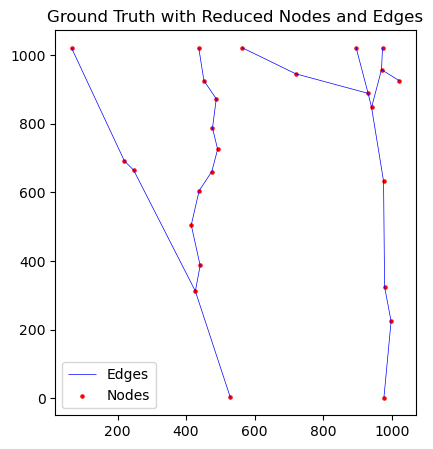

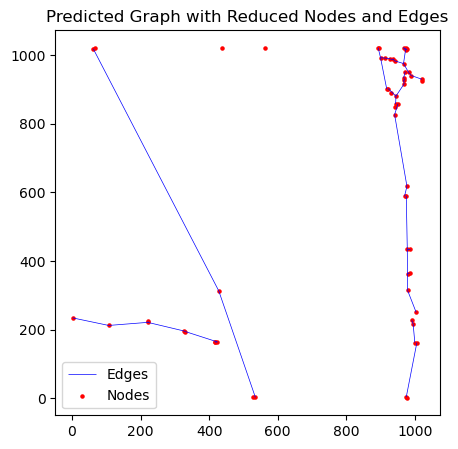

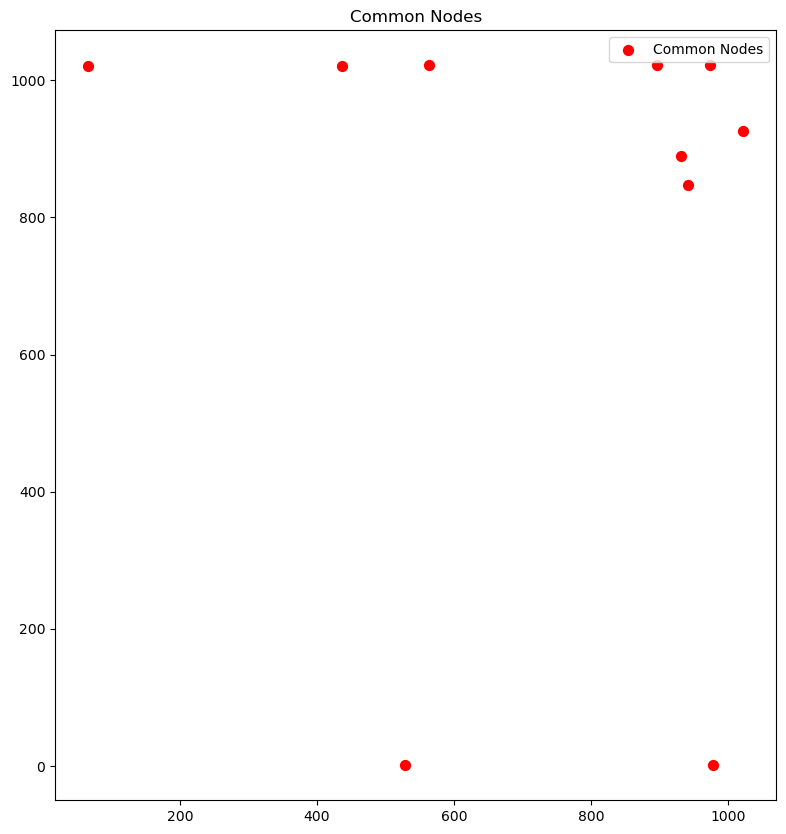

Missing nodes: 16, Broken paths: 1
-0.37777777777777777


In [212]:
import cv2
from PIL import Image
import random

# read mask
pred_mask_path = r"C:\WORKS\Master_Thesis\Codes\pred_masks"
truth_mask_path = r"C:\WORKS\Master_Thesis\Train_Datasets\DeepGlobe"
pred =  "392105_sat_lad_0.1.png" #'11545_sat_lad_0.1.png'
truth = '392105_mask.png'



# load path for truth and predicted
pred_path = os.path.join(pred_mask_path, pred)
truth_path = os.path.join(truth_mask_path, truth)


pred_path = r"C:\WORKS\Master_Thesis\Codes\masks_2_geojson\CAF_B5_UN_Testing\6_pred.png"
truth_path = r"C:\WORKS\Master_Thesis\UN_Dataset\CAF_images_masks\6_mask.png"


# CAF_ablation_no_diceloss_noconnectivity
# CAF_ablation_no_connectivity_loss
# CAF_B5_UN_Testing


# load the predicted and truth mask
loaded_pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
loaded_truth = cv2.imread(truth_path, cv2.IMREAD_GRAYSCALE)

# # normalise mask
loaded_pred = loaded_pred/255
loaded_truth = loaded_truth/255


# # convert loaded_pred to array
# loaded_pred = np.array(loaded_pred).astype(np.uint8)

# loaded_pred = Image.fromarray(loaded_pred)


# # # resize loaded mask
resized_loaded_pred = cv2.resize(loaded_pred, (1024, 1024))

resized_loaded_pred = np.array(resized_loaded_pred).astype(np.uint8)
loaded_truth = loaded_truth.astype(np.uint8)



lines_pred = build_graph(resized_loaded_pred)
lines_truth = build_graph(loaded_truth)



import geopandas as gpd
from shapely import wkt
import networkx as nx
from shapely.geometry import LineString, Point


#----------- for ground truth
# Convert the list of LineString WKT to a list of Shapely geometries
geometries = [wkt.loads(line) for line in lines_truth]
# Create a GeoDataFrame
gt_gdf = gpd.GeoDataFrame(geometry=geometries)
gt_graph = nx.DiGraph()
# for _, row in gt_gdf.iterrows():
#     if isinstance(row.geometry, LineString):
#         coords = list(row.geometry.coords)
#         for i in range(len(coords)-1):
#             node1 = coords[i]
#             node2 = coords[i + 1]
#             weight = row.get('weight', 1.0)
#             gt_graph.add_edge(node1, node2, weight=weight)


#----------- for predicted 
# Convert the list of LineString WKT to a list of Shapely geometries
geometries = [wkt.loads(line) for line in lines_pred]
# Create a GeoDataFrame
pred_gdf = gpd.GeoDataFrame(geometry=geometries)
pred_graph = nx.DiGraph()
# for _, row in pred_gdf.iterrows():
#     if isinstance(row.geometry, LineString):
#         coords = list(row.geometry.coords)
#         for i in range(len(coords)-1):
#             node1 = coords[i]
#             node2 = coords[i + 1]
#             weight = row.get('weight', 1.0)
#             pred_graph.add_edge(node1, node2, weight=weight)


            
def simplify_linestrings(linestrings, tolerance=5.0):
    """
    Simplify LineStrings to reduce the number of points.

    Parameters:
        linestrings (list of shapely.geometry.LineString): LineStrings to simplify.
        tolerance (float): Simplification tolerance; larger values simplify more.

    Returns:
        List of simplified LineStrings.
    """
    simplified_linestrings = [ls.simplify(tolerance, preserve_topology=True) for ls in linestrings]
    return simplified_linestrings


# def extract_significant_nodes(linestrings):
#     """
#     Extract only significant nodes from LineStrings (start, end, and points of curvature).

#     Parameters:
#         linestrings (list of shapely.geometry.LineString): Road LineStrings.

#     Returns:
#         List of significant nodes as coordinate tuples.
#     """
#     significant_nodes = []
#     for ls in linestrings:
#         coords = list(ls.coords)
#         # Always include start and end points
#         significant_nodes.extend([coords[0], coords[-1]])
#     return list(set(significant_nodes))  # Remove duplicates

def extract_significant_nodes(linestrings):
    start_end_nodes = set()  # Store only start and end points
    intermediate_nodes = set()  # Track intermediate nodes to exclude them later

    for ls in linestrings:
        coords = list(ls.coords)
        if len(coords) > 1:  # Ensure valid LineString
            start, end = coords[0], coords[-1]  # Get start and end points
            
            # Add start and end nodes
            start_end_nodes.add(start)
            start_end_nodes.add(end)
            
            # Track all intermediate points
            for intermediate in coords[1:-1]:
                intermediate_nodes.add(intermediate)

    # Remove any start/end nodes that also appear as intermediate nodes
    significant_nodes = start_end_nodes - intermediate_nodes

    return list(significant_nodes)  # Convert set back to list


def add_nodes_to_graphs(gt_graph, pred_graph, new_nodes, tolerance=10.0):
    """
    Add nodes to both the ground truth and predicted graphs.

    Parameters:
        gt_graph (networkx.Graph): Ground truth graph.
        pred_graph (networkx.Graph): Predicted graph.
        new_nodes (list of tuples): List of coordinates for new nodes.
        tolerance (float): Distance to connect new nodes to existing ones.
    """
    for node in new_nodes:
        # Add to ground truth graph
        gt_graph.add_node(node)
        for existing_node in gt_graph.nodes():
            if existing_node != node:
                dist = Point(existing_node).distance(Point(node))
                if dist <= tolerance:
                    gt_graph.add_edge(node, existing_node, weight=dist)
        
        # Mirror in predicted graph
        pred_graph.add_node(node)
        for existing_node in pred_graph.nodes():
            if existing_node != node:
                dist = Point(existing_node).distance(Point(node))
                if dist <= tolerance:
                    pred_graph.add_edge(node, existing_node, weight=dist)


def add_edges_from_linestrings(graph, linestrings):
    """
    Add edges to a graph based on LineStrings.

    Parameters:
        graph (nx.Graph): Graph to add edges to.
        linestrings (list of shapely.geometry.LineString): List of LineStrings.
    """
    for line in linestrings:
        coords = list(line.coords)
        for i in range(len(coords) - 1):
            node1 = tuple(coords[i])
            node2 = tuple(coords[i + 1])
            if not graph.has_edge(node1, node2):  # Avoid duplicate edges
                graph.add_edge(node1, node2, weight=line.length)

def visualize_geospatial_graph_with_edges(graph, title="Geospatial Graph"):
    """
    Visualize a geospatial graph with both nodes and edges.

    Parameters:
        graph (nx.Graph): Graph to visualize.
        title (str): Title of the plot.
    """
    import matplotlib.pyplot as plt
    import geopandas as gpd
    from shapely.geometry import Point, LineString

    # Extract nodes and edges
    nodes = [Point(node) for node in graph.nodes]
    edges = [
        LineString([Point(node1), Point(node2)]) for node1, node2 in graph.edges
    ]

    # Convert to GeoDataFrames
    node_gdf = gpd.GeoDataFrame(geometry=nodes)
    edge_gdf = gpd.GeoDataFrame(geometry=edges)

    # Plot
    fig, ax = plt.subplots(figsize=(5, 5))
    edge_gdf.plot(ax=ax, color="blue", linewidth=0.5, label="Edges")
    node_gdf.plot(ax=ax, color="red", markersize=5, label="Nodes")
    plt.title(title)
    plt.legend()
    plt.show()


def visualize_common_nodes(gt_graph, pred_graph, title="Common Nodes"):
    """
    Visualize nodes that are common to both the ground truth and predicted graphs.
    """
    import matplotlib.pyplot as plt
    import geopandas as gpd
    from shapely.geometry import Point

    # Find common nodes
    # common_nodes = set(gt_graph.nodes).intersection(set(pred_graph.nodes))
    common_nodes = list(set(gt_graph.nodes()) & set(pred_graph.nodes()))

    # Extract common nodes as Points
    nodes = [Point(node) for node in common_nodes]

    # Convert to GeoDataFrame
    node_gdf = gpd.GeoDataFrame(geometry=nodes)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    node_gdf.plot(ax=ax, color="red", markersize=50, label="Common Nodes")
    plt.title(title)
    plt.legend()
    plt.show()



gt_linestrings = [feature.geometry for feature in gt_gdf.itertuples()]
pred_linestrings = [feature.geometry for feature in pred_gdf.itertuples()]
tolerance = 10.0  # Adjust tolerance for simplification
simplified_linestrings = simplify_linestrings(gt_linestrings, tolerance=tolerance)
simplified_linestrings_pred = simplify_linestrings(pred_linestrings, tolerance=tolerance)

# Extract significant nodes from simplified LineStrings
new_nodes = extract_significant_nodes(simplified_linestrings)

# Add these nodes and edges to both graphs
add_nodes_to_graphs(gt_graph, pred_graph, new_nodes, tolerance=15.0)
add_edges_from_linestrings(gt_graph, simplified_linestrings)
add_edges_from_linestrings(pred_graph, simplified_linestrings_pred)




# Visualize updated graphs with edges
visualize_geospatial_graph_with_edges(gt_graph, title="Ground Truth with Reduced Nodes and Edges")
visualize_geospatial_graph_with_edges(pred_graph, title="Predicted Graph with Reduced Nodes and Edges")

visualize_common_nodes(gt_graph, pred_graph)




import networkx as nx
import numpy as np
from itertools import combinations

# def calculate_pea_all(gt_graph, pred_graph):
#     common_nodes = list(set(gt_graph.nodes()) & set(pred_graph.nodes()))  # Get common nodes
#     print(len(common_nodes))
#     node_pairs = list(combinations(common_nodes, 2))  # Generate node pairs from common nodes
    
#     pea_scores = []
#     for node1, node2 in node_pairs:
#         # Check path existence in both graphs
#         has_path_gt = nx.has_path(gt_graph, node1, node2)
#         has_path_pred = nx.has_path(pred_graph, node1, node2)
        
#         # Compute PEA score
#         pea_score = 1 if has_path_gt == has_path_pred else 0
#         pea_scores.append(pea_score)
    
#     # Penalize for missing nodes in predicted graph
#     missing_nodes = len(set(gt_graph.nodes()) - set(pred_graph.nodes()))
#     total_pea_score = np.sum(pea_scores) - missing_nodes  # Subtract 1 for each missing node
    
#     # Normalize by the total number of node pairs
#     normalization_factor = len(node_pairs)
#     final_score = total_pea_score / normalization_factor if normalization_factor > 0 else 0

#     # Find indices of all zeros
#     pea_indices = [index for index, value in enumerate(pea_scores) if value == 0]
#     print(f'{pea_indices=}')

#     return final_score, pea_scores  #

import networkx as nx
import numpy as np
from itertools import combinations

import networkx as nx
import numpy as np
from itertools import combinations

def calculate_pea_all(gt_graph, pred_graph):
    """
    Custom metric to evaluate road network connectivity by penalizing missing/broken paths.

    Parameters:
        gt_graph (networkx.Graph): Ground truth road network.
        pred_graph (networkx.Graph): Predicted road network.

    Returns:
        float: Normalized connectivity score.
    """
    common_nodes = list(set(gt_graph.nodes()) & set(pred_graph.nodes()))
    
    if len(common_nodes) < 2:
        return 0  # No valid comparisons possible
    
    node_pairs = list(combinations(common_nodes, 2))  # Generate node pairs
    
    total_score = 0
    broken_penalty = 0
    
    for node1, node2 in node_pairs:
        # Check if there's a path in ground truth
        path_exists_gt = nx.has_path(gt_graph, node1, node2)
        path_exists_pred = nx.has_path(pred_graph, node1, node2)
        
        if path_exists_gt and path_exists_pred:
            total_score += 1  # Correctly predicted path
        elif path_exists_gt and not path_exists_pred:
            total_score -= 1  # Penalize missing path
            broken_penalty += 1  # Additional broken edge count
        elif not path_exists_gt and path_exists_pred:
            total_score += 0  # Extra paths don't add penalty
        
    # Adjust for missing nodes in predicted graph
    missing_nodes = len(set(gt_graph.nodes()) - set(pred_graph.nodes()))
    total_score -= missing_nodes  # Penalize for missing nodes
    
    # Normalize using the max possible paths
    max_possible_score = len(node_pairs)
    final_score = total_score / max_possible_score if max_possible_score > 0 else 0
    
    print(f'Missing nodes: {missing_nodes}, Broken paths: {broken_penalty}')
    
    return final_score




value = calculate_pea_all(gt_graph, pred_graph)
print(value)




In [ ]:
# pea_indices=[13, 45, 49, 61] - for finetuning

Missing nodes: 16, Broken paths: 1
-0.37777777777777777

In [ ]:
import numpy as np

# def calculate_pea(gt_graph, pred_graph, node_pairs):
#     pea_scores = []
#     for node1, node2 in node_pairs:
#         has_path_gt = nx.has_path(gt_graph, node1, node2)
#         has_path_pred = nx.has_path(pred_graph, node1, node2)
#         pea_score = 1 if has_path_gt == has_path_pred else 0
#         pea_scores.append(pea_score)
#     return np.mean(pea_scores), pea_scores

# # Example usage
# common_nodes = list(set(gt_graph.nodes()) & set(pred_graph.nodes()))
# node_pairs = [(n1, n2) for i, n1 in enumerate(common_nodes) for n2 in common_nodes[i+1:]]

(0.7272727272727273, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])


In [ ]:
0.7272727272727273 - un-testing

0.9047619047619048 - no diceloss - no connectivity



#### Testing

In [21]:
def calculate_jaccard(gt_graph, pred_graph, node_pairs):
    jaccard_scores = []
    for node1, node2 in node_pairs:
        try:
            path_gt = nx.shortest_path(gt_graph, source=node1, target=node2)
            path_pred = nx.shortest_path(pred_graph, source=node1, target=node2)
            set_gt = set(path_gt)
            set_pred = set(path_pred)
            intersection = len(set_gt.intersection(set_pred))
            union = len(set_gt.union(set_pred))
            jaccard_score = intersection / union if union != 0 else 0
            jaccard_scores.append(jaccard_score)
        except nx.NetworkXNoPath:
            jaccard_scores.append(0)  # No path results in a score of 0
    return np.mean(jaccard_scores), jaccard_scores


# value = calculate_jaccard(gt_graph, pred_graph, node_pairs)
# print(value)

def calculate_pea(gt_graph, pred_graph, node_pairs):
    pea_scores = []
    for node1, node2 in node_pairs:
        has_path_gt = nx.has_path(gt_graph, node1, node2)
        has_path_pred = nx.has_path(pred_graph, node1, node2)
        pea_score = 1 if has_path_gt == has_path_pred else 0
        pea_scores.append(pea_score)
    return np.mean(pea_scores), pea_scores


value = calculate_pea(gt_graph, pred_graph, node_pairs)
print(value)


def calculate_nspd(gt_graph, pred_graph, node_pairs, weight='weight', epsilon=1e-5):
    nspd_scores = []
    for node1, node2 in node_pairs:
        try:
            d_gt = nx.shortest_path_length(gt_graph, source=node1, target=node2, weight=weight)
            d_pred = nx.shortest_path_length(pred_graph, source=node1, target=node2, weight=weight)
            nspd_score = abs(d_pred - d_gt) / (max(d_pred, d_gt) + epsilon)
            nspd_scores.append(nspd_score)
        except nx.NetworkXNoPath:
            nspd_scores.append(1)  # No path results in maximum disagreement
    return np.mean(nspd_scores), nspd_scores

# value = calculate_nspd(gt_graph, pred_graph, node_pairs)
# print(value)


(0.7555555555555555, [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0])


#### Existed before

In [22]:
for i,j in node_pairs:
    print(i, j)




(147.0, 902.0) (12.0, 1023.0)
(147.0, 902.0) (363.0, 1023.0)
(147.0, 902.0) (209.0, 965.0)
(147.0, 902.0) (884.0, 0.0)
(147.0, 902.0) (565.0, 443.0)
(147.0, 902.0) (193.0, 1023.0)
(147.0, 902.0) (1023.0, 766.0)
(147.0, 902.0) (0.0, 24.0)
(147.0, 902.0) (565.0, 438.0)
(12.0, 1023.0) (363.0, 1023.0)
(12.0, 1023.0) (209.0, 965.0)
(12.0, 1023.0) (884.0, 0.0)
(12.0, 1023.0) (565.0, 443.0)
(12.0, 1023.0) (193.0, 1023.0)
(12.0, 1023.0) (1023.0, 766.0)
(12.0, 1023.0) (0.0, 24.0)
(12.0, 1023.0) (565.0, 438.0)
(363.0, 1023.0) (209.0, 965.0)
(363.0, 1023.0) (884.0, 0.0)
(363.0, 1023.0) (565.0, 443.0)
(363.0, 1023.0) (193.0, 1023.0)
(363.0, 1023.0) (1023.0, 766.0)
(363.0, 1023.0) (0.0, 24.0)
(363.0, 1023.0) (565.0, 438.0)
(209.0, 965.0) (884.0, 0.0)
(209.0, 965.0) (565.0, 443.0)
(209.0, 965.0) (193.0, 1023.0)
(209.0, 965.0) (1023.0, 766.0)
(209.0, 965.0) (0.0, 24.0)
(209.0, 965.0) (565.0, 438.0)
(884.0, 0.0) (565.0, 443.0)
(884.0, 0.0) (193.0, 1023.0)
(884.0, 0.0) (1023.0, 766.0)
(884.0, 0.0) (0.0

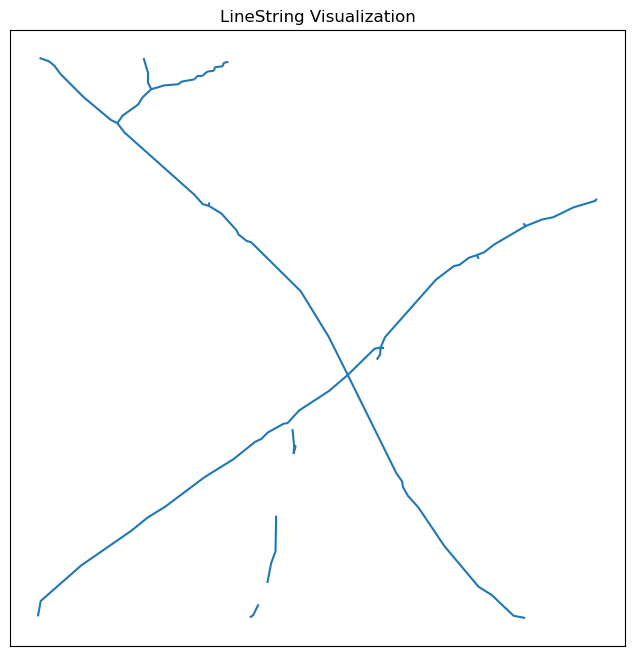

In [13]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the LineStrings
pred_gdf.plot(ax=ax)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add a title
plt.title("LineString Visualization")

ax.invert_yaxis()

# Show the plot
plt.show()


#### Trying to insert nodes ourselves|

In [11]:
def extract_and_add_aligned_nodes(gt_linestrings, pred_graph, spacing=10.0):
    """
    Extract nodes from ground truth LineStrings and align them to the predicted graph.

    Parameters:
        gt_linestrings (list of shapely.geometry.LineString): Ground truth LineStrings.
        pred_graph (nx.Graph): Predicted graph to align nodes to.
        spacing (float): Spacing between nodes along the LineStrings.

    Returns:
        List of nodes added to both graphs.
    """
    import networkx as nx
    from shapely.geometry import Point

    def extract_nodes_from_line(line, spacing):
        """Generate nodes along a LineString at specified spacing."""
        length = line.length
        return [line.interpolate(dist).coords[0] for dist in range(0, int(length), int(spacing))]

    aligned_nodes = set()

    # Extract nodes from ground truth LineStrings
    for line in gt_linestrings:
        nodes = extract_nodes_from_line(line, spacing)
        aligned_nodes.update(nodes)

    # Add nodes to the predicted graph
    for node in aligned_nodes:
        pred_graph.add_node(node)

    return list(aligned_nodes)


def add_nodes_to_gt_graph(gt_graph, aligned_nodes):
    """
    Add nodes to the ground truth graph.

    Parameters:
        gt_graph (nx.Graph): Ground truth graph.
        aligned_nodes (list): List of node coordinates to add.
    """
    for node in aligned_nodes:
        gt_graph.add_node(node)


In [ ]:
# Extract nodes from ground truth and align to predicted graph
aligned_nodes = extract_and_add_aligned_nodes(gt_linestrings, pred_graph, spacing=15.0)

# Add these aligned nodes to the ground truth graph
add_nodes_to_gt_graph(gt_graph, aligned_nodes)

# Visualize the updated graphs
visualize_geospatial_graph(gt_graph, title="Aligned Ground Truth Graph")
visualize_geospatial_graph(pred_graph, title="Aligned Predicted Graph")
